In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys, copy, emcee, corner

%matplotlib inline
%load_ext autoreload

sys.path.append('./ligbind/')
import ligbind as lb

In [159]:
dat = lb.WymSim(sets=1,noise=0.05,reps=1)

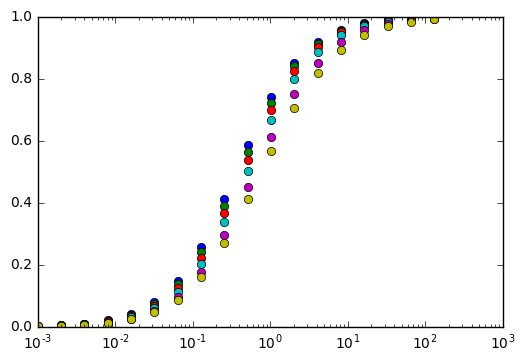

In [160]:
lb.semlog(dat.ligs,dat.bfrac,'o')

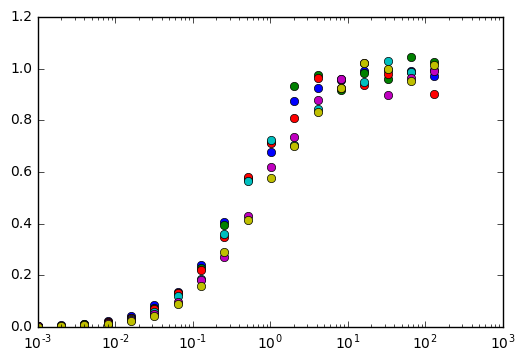

In [161]:
lb.semlog(dat.ligs,dat.meanset[0],'o')

In [183]:
#vary all Wym model parameters
#variance weighted by y-value (not y squared)
def lnlik4p(parms,rtot,data,ligs):
    datac = np.concatenate(data)
    modparms = parms[0:-1]
    rtots = rtot
    f = parms[-1]
    model = lb.models.wymfunc(modparms,ligs,rtots)
    invsig2 = 1.0/np.square(f*datac) #do I need to change this to DATAC?
    return -0.5*(np.sum((datac-model)**2*invsig2 - np.log(invsig2)))

#uniform prior based on bounds
def lnpri4p(allfit,bounds):
    assert len(bounds) == len(allfit)
    if all([bounds[i][0] <= allfit[i] <= bounds[i][1] for i in range(len(bounds))]) is True:
        return 0.0
    else:
        return -np.inf
    
def lnprob4p(allfit,bounds,rtot,data,ligs):
    lp = lnpri4p(allfit,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlik4p(allfit,rtot,data,ligs)

In [184]:
nll = lambda *args: -lnlik4p(*args)

In [185]:
g1 = np.array([4.,6.,13.,170.,0.01])
g2 = np.array([1.,4.,0.5,100.,0.01])
g3 = np.array([15.,6.,0.8,245.,0.01])

In [186]:
bnds = ((0.01,100.),(0.01,100.),(0.001,10.),(1.,1000.),(1e-6,0.1))

In [225]:
nll_res = sp.optimize.minimize(nll,g1,args=(dat.rtot,dat.bfrac,dat.ligs),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-12})

In [226]:
nll_res.x

array([  2.99999999e+00,   1.99999998e+00,   1.00000005e-01,
         9.99999974e+01,   1.00000000e-06])

In [189]:
nll_resnoise = sp.optimize.minimize(nll,g1,bounds=bnds,args=(dat.rtot,dat.meanset[0],dat.ligs))

In [190]:
nll_resnoise.x

array([  2.92608955e+00,   1.71786210e+00,   9.29727627e-02,
         8.07210073e+01,   4.84160155e-02])

In [191]:
sp.optimize.minimize(nll,g3,args=(dat.rtot,dat.meanset[0],dat.ligs),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-12})

      fun: -472.71771557542786
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.09272616e-04,  -2.27373675e-05,   1.47792889e-04,
         0.00000000e+00,  -1.26192390e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 480
      nit: 59
   status: 0
  success: True
        x: array([  2.92610476e+00,   1.71788904e+00,   9.29936599e-02,
         8.07247989e+01,   4.84160274e-02])

In [192]:
sp.optimize.minimize(nll,g1,args=(dat.rtot,dat.meanset[0],dat.ligs),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-12})

      fun: -472.7177155750519
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.61701813e-04,  -1.25055521e-04,   5.11590770e-05,
        -5.68434189e-06,   1.76783033e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 378
      nit: 41
   status: 0
  success: True
        x: array([  2.92610690e+00,   1.71788678e+00,   9.29922762e-02,
         8.07248875e+01,   4.84160602e-02])

In [193]:
sp.optimize.minimize(nll,g2,args=(dat.rtot,dat.meanset[0],dat.ligs),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-12})

      fun: -472.71771557563079
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.54747351e-05,  -7.95807864e-05,  -6.25277607e-05,
         5.68434189e-06,  -2.61479727e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 528
      nit: 69
   status: 0
  success: True
        x: array([  2.92610501e+00,   1.71788699e+00,   9.29912867e-02,
         8.07246679e+01,   4.84160382e-02])

In [194]:
(0.0263*dat.meanset[0][0])/dat.meanset[0][0]

array([ 0.0263,  0.0263,  0.0263,  0.0263,  0.0263,  0.0263,  0.0263,
        0.0263,  0.0263,  0.0263,  0.0263,  0.0263,  0.0263,  0.0263,
        0.0263,  0.0263,  0.0263,  0.0263])

In [195]:
0.0263*2

0.0526

In [196]:
ndim4p, nwalkers4p = 5, 100
pos4p = [np.random.normal(1.,0.1)*nll_resnoise.x for i in range(nwalkers4p)]

In [197]:
sampler = emcee.EnsembleSampler(nwalkers4p,ndim4p,lnprob4p,args=(bnds,dat.rtot,dat.meanset[0],dat.ligs))

In [198]:
sampler.run_mcmc(pos4p,2000);

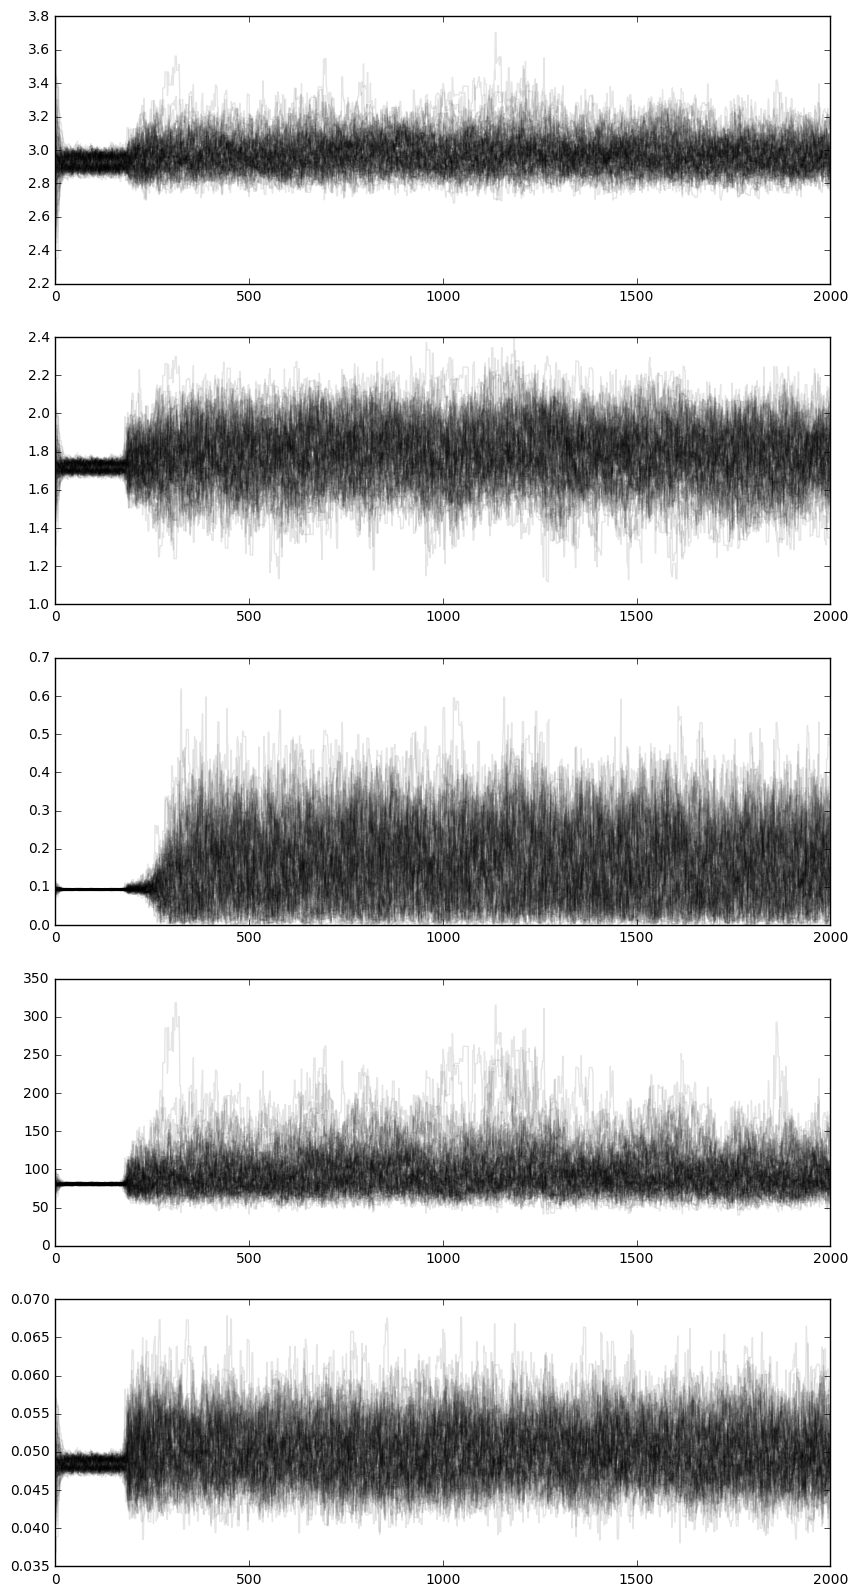

In [199]:
fig = plt.figure(figsize=(10,20))
for i in range(5):
    ax1 = fig.add_subplot(5,1,(i+1))
    ax1.plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.1);

In [200]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim4p))

In [201]:
np.median(samples,axis=0)

array([  2.96360747e+00,   1.77827893e+00,   1.46782974e-01,
         9.06034655e+01,   4.96642964e-02])

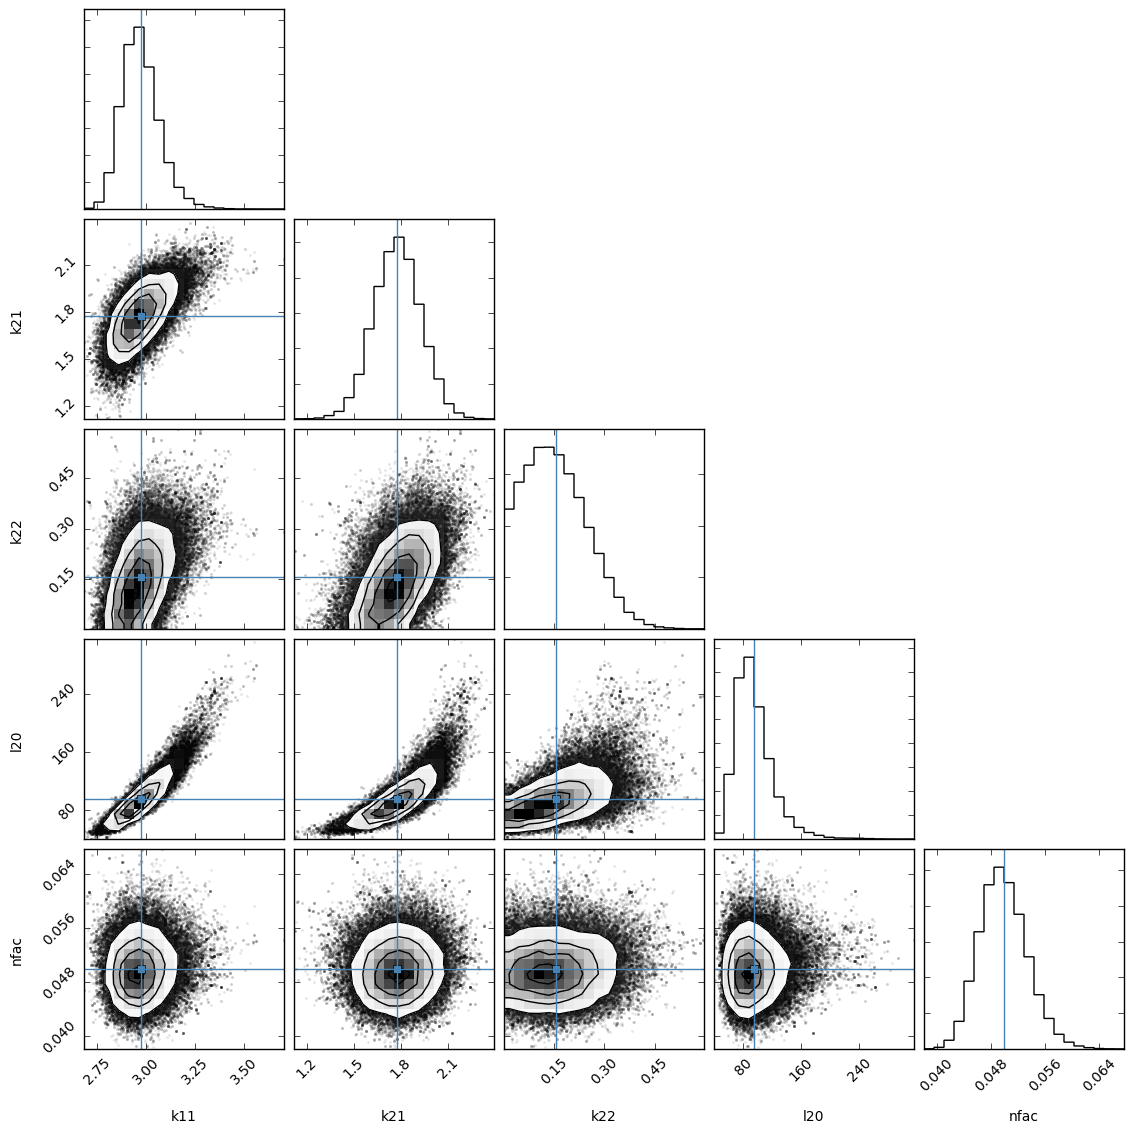

In [202]:
fig=corner.corner(samples, labels=['k11','k21','k22','l20','nfac'],truths=np.mean(samples,axis=0))

In [204]:
prcs = np.percentile(samples, [16, 50, 84], axis=0)

In [215]:
prcs[:,4]

array([ 0.04640541,  0.0496643 ,  0.0533281 ])

In [216]:
def novarlnlik4p(parms,rtot,data,ligs):
    datac = np.concatenate(data)
    modparms = parms[0:-1]
    rtots = rtot
    f = parms[-1]
    model = lb.models.wymfunc(modparms,ligs,rtots)
    #invsig2 = 1.0/np.square(f*datac) #do I need to change this to DATAC?
    invsig2 = 1.0
    return -0.5*(np.sum((datac-model)**2*invsig2 - np.log(invsig2)))

In [217]:
nll_novar = lambda *args: -novarlnlik4p(*args)

In [230]:
nll_novar_res = sp.optimize.minimize(nll_novar,g1,args=(dat.rtot,dat.meanset[0],dat.ligs),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-12})

In [231]:
nll_novar_res.x

array([  2.90106448e+00,   1.69065049e+00,   1.15873209e-01,
         7.56210277e+01,   1.00000000e-02])

In [232]:
def lsfit4p(parmguess,rtot,data,ligs):
    datac = np.concatenate(data)
    calc = lb.models.wymfunc(parmguess,ligs,rtot)
    return (calc-datac)

In [234]:
lsbnds = tuple([i[0] for i in bnds][:-1]), tuple([i[1] for i in bnds][:-1])

In [242]:
ls_res = sp.optimize.least_squares(lsfit4p,g2[:-1],bounds=lsbnds,args=(dat.rtot,dat.meanset[0],dat.ligs))

In [243]:
ls_res.x

array([  2.90116985,   1.69087538,   0.11599736,  75.64311748])

In [244]:
nll_resnoise.x

array([  2.92608955e+00,   1.71786210e+00,   9.29727627e-02,
         8.07210073e+01,   4.84160155e-02])

In [245]:
th = sp.optimize.minimize(nll,g3,args=(dat.rtot,dat.meanset[0],dat.ligs),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-12})

In [247]:
th.x

array([  2.92610476e+00,   1.71788904e+00,   9.29936599e-02,
         8.07247989e+01,   4.84160274e-02])

In [254]:
fitted = lb.models.wymfunc(dat.parms,dat.ligs,dat.rtot)

In [255]:
flatdat = np.concatenate(dat.meanset[0])

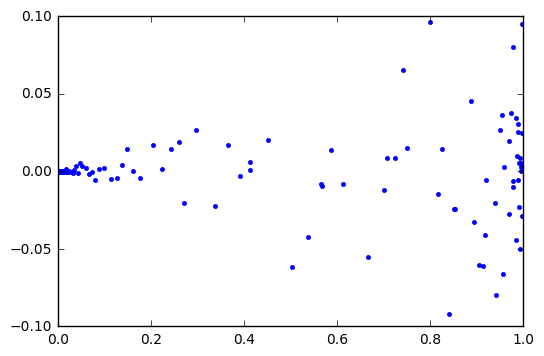

In [256]:
plt.plot(fitted,(fitted-flatdat),'.')

In [257]:
def wymresplot(fittedparms,ligs,rtot,data):
    fitted = lb.models.wymfunc(fittedparms,ligs,rtot)
    flatdat = np.concatenate(data)
    plt.plot(fitted,(fitted-flatdat),'.')

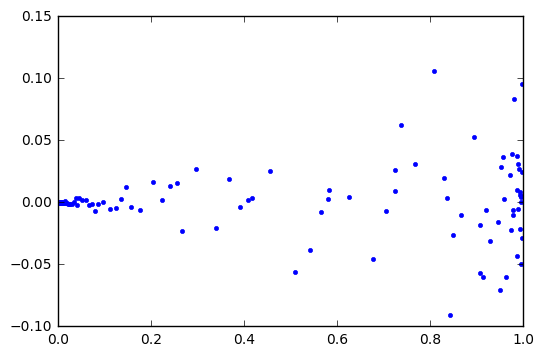

In [261]:
wymresplot(nll_novar_res.x,dat.ligs,dat.rtot,dat.meanset[0])

In [262]:
dat.rtot

array([ 0.001 ,  0.0025,  0.005 ,  0.01  ,  0.025 ,  0.05  ])

In [263]:
bnds

((0.01, 100.0), (0.01, 100.0), (0.001, 10.0), (1.0, 1000.0), (1e-06, 0.1))

In [281]:
bndsal = ((3., 3.), (2., 2.), (0.1, 0.1), (100., 100.),(1e-5,1e-1),(1e-5,1e-1),(1e-5,1e-1),(1e-4,1e-1),(1e-4,1e-1),(1e-3,1.),(1e-06, 0.1))

In [282]:
#Standard deviation weighted by y - the data (not the model like previous)
def lnlikMp(guess,data,ligs):
    datac = np.concatenate(data)
    modparms = guess[0:4]
    rtots = guess[4:-1]
    f = guess[-1]
    model = lb.models.wymfunc(modparms,ligs,rtots)
    invsig2 = 1.0/np.square(f*datac)
    return -0.5*(np.sum((datac-model)**2*invsig2 - np.log(invsig2)))

#uniform prior based on bounds
def lnpriMp(guess,bounds):
    assert len(bounds) == len(allfit)
    if all([bounds[i][0] <= allfit[i] <= bounds[i][1] for i in range(len(bounds))]) is True:
        return 0.0
    else:
        return -np.inf
    
def lnprobMp(guess,bounds,data,ligs):
    lp = lnpriMp(allfit,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikMp(allfit,rtot,data,ligs)

In [283]:
nll_all = lambda *args: -lnlikMp(*args)

In [284]:
guess_all = np.array([4.60,
                  5.30,
                  3.40e-01,
                  5.30e+02,
                  5.70e-04,
                  1.02e-03,
                  2.18e-03,
                  2.85e-03,
                  5.48e-03,
                  1.06e-02,
                  0.02])

In [285]:
nll_all_res = sp.optimize.minimize(nll_all,guess_all,args=(dat.meanset[0],dat.ligs),method='L-BFGS-B',bounds=bndsal,options={'ftol':1e-12})

In [286]:
nll_all_res.x

array([  3.00000000e+00,   2.00000000e+00,   1.00000000e-01,
         1.00000000e+02,   1.15495412e-03,   2.85077276e-03,
         4.74366770e-03,   1.05867484e-02,   3.04750532e-02,
         5.90384091e-02,   4.89374698e-02])

In [287]:
dat.parms

array([   3. ,    2. ,    0.1,  100. ])

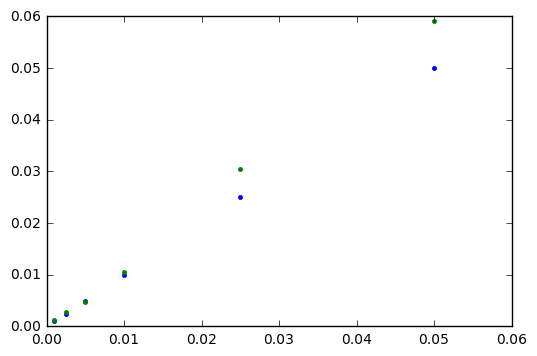

In [289]:
plt.plot(dat.rtot,dat.rtot,'.')
plt.plot(dat.rtot,nll_all_res.x[4:-1],'.')

In [290]:
lsbndsal = tuple([i[0] for i in bndsal][:-1]), tuple([i[1] for i in bndsal][:-1])

In [291]:
lsbndsal

((3.0, 2.0, 0.1, 100.0, 1e-05, 1e-05, 1e-05, 0.0001, 0.0001, 0.001),
 (3.0, 2.0, 0.1, 100.0, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0))

In [292]:
lsbndsalf = ((3.0, 2.0, 0.1, 100.0, 1e-05, 1e-05, 1e-05, 0.0001, 0.0001, 0.001),
 (3.001, 2.001, 0.101, 100.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0))

In [298]:
lsbndsalf

((3.0, 2.0, 0.1, 100.0, 1e-05, 1e-05, 1e-05, 0.0001, 0.0001, 0.001),
 (3.001, 2.001, 0.101, 100.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0))

In [300]:
def lsfitallp(parmguess,data,ligs):
    datac = np.concatenate(data)
    calc = lb.models.wymfunc(parmguess[0:4],ligs,parmguess[4:])
    return (calc-datac)

In [303]:
gress = guess_all[:-1]

In [304]:
ls_resal = sp.optimize.least_squares(lsfitallp,gress,bounds=lsbndsalf,args=(dat.meanset[0],dat.ligs))

ValueError: `x0` is infeasible.

In [306]:
gress = np. array([  3.,   2.,   0.1,
         100.,   5.70000000e-04,   1.02000000e-03,
         2.18000000e-03,   2.85000000e-03,   5.48000000e-03,
         1.06000000e-02])

In [314]:
ls_resal = sp.optimize.least_squares(lsfitallp,gress,bounds=lsbndsalf,args=(dat.meanset[0],dat.ligs),ftol=1e-12)

In [315]:
ls_resal.x

array([  3.00100000e+00,   2.00000000e+00,   1.01000000e-01,
         1.00037946e+02,   2.30007916e-03,   1.62775608e-03,
         3.94227590e-03,   8.54975137e-03,   2.49617230e-02,
         3.88186283e-02])

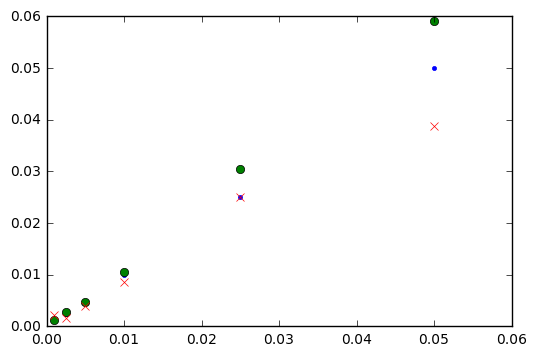

In [316]:
plt.plot(dat.rtot,dat.rtot,'.')
plt.plot(dat.rtot,nll_all_res.x[4:-1],'o')
plt.plot(dat.rtot,ls_resal.x[4:],'x')

In [313]:
dat.parms

array([   3. ,    2. ,    0.1,  100. ])